In [85]:
import numpy as np
import pandas as pd
import yfinance as yf

In [86]:
nifty = yf.Ticker('^NSEI')
nifty_data = nifty.history(period = 'max')

nifty_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,0,0.0,0.0
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,0,0.0,0.0
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,0,0.0,0.0
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,0,0.0,0.0
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,0,0.0,0.0


In [87]:
print(nifty_data.shape)

(4506, 7)


In [88]:
df = nifty_data
# dates = df.index

# cur_dated = []
# for d in dates:
#     cur_dated.append(str(d)[:10])

# cur_dated = pd.Series(cur_dated)
# df.index = cur_dated
# df.head()

df.index = df.index.strftime('%Y-%m-%d')

<Axes: xlabel='Date'>

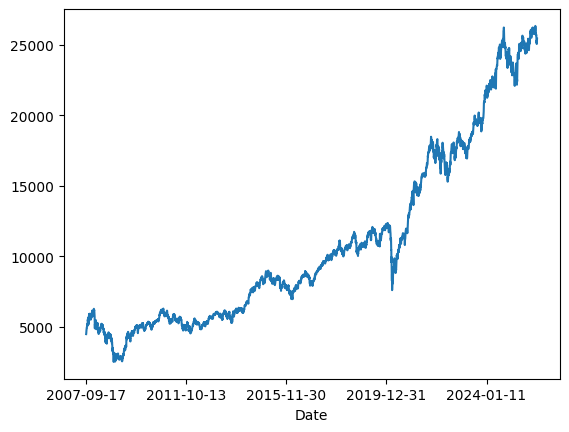

In [89]:
nifty_data['Close'].plot(kind = 'line')

<Axes: xlabel='Date'>

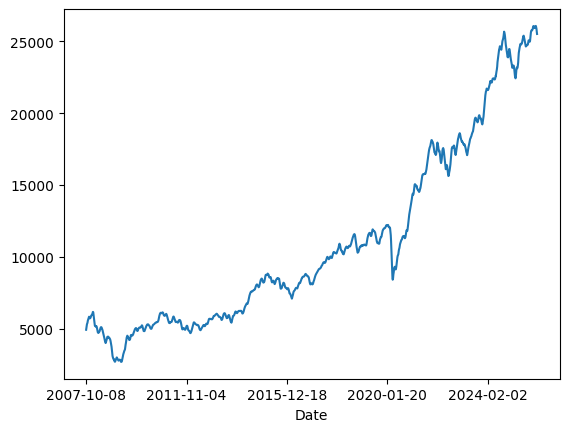

In [90]:
df['Close'].rolling(window = 15).mean().dropna().plot(kind = 'line')

## Seasonality

In [91]:
df['date'] = pd.to_datetime(df.index)

In [92]:
df['month'] = df['date'].dt.strftime('%Y-%m')
df.index = df['date'].dt.strftime('%Y-%m')

In [93]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,month
date,,,,,,,,,
2007-09,4518.450195,4549.049805,4482.850098,4494.649902,0,0.0,0.0,2007-09-17,2007-09
2007-09,4494.100098,4551.799805,4481.549805,4546.200195,0,0.0,0.0,2007-09-18,2007-09
2007-09,4550.250000,4739.000000,4550.250000,4732.350098,0,0.0,0.0,2007-09-19,2007-09
2007-09,4734.850098,4760.850098,4721.149902,4747.549805,0,0.0,0.0,2007-09-20,2007-09
2007-09,4752.950195,4855.700195,4733.700195,4837.549805,0,0.0,0.0,2007-09-21,2007-09


<Axes: xlabel='month'>

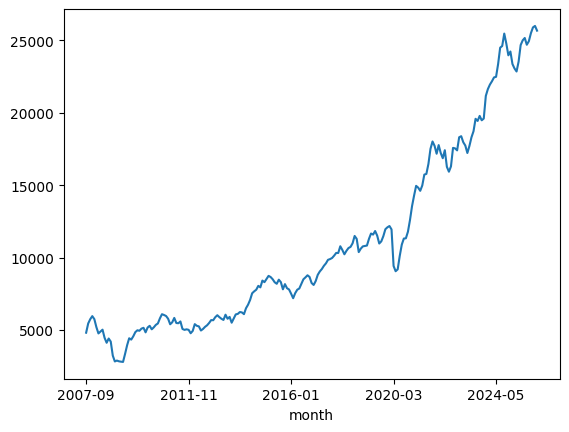

In [94]:
df['Close'].groupby(df['month']).agg('mean').plot()

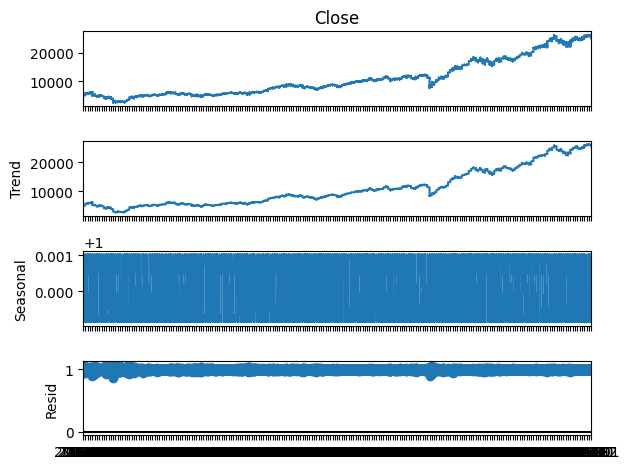

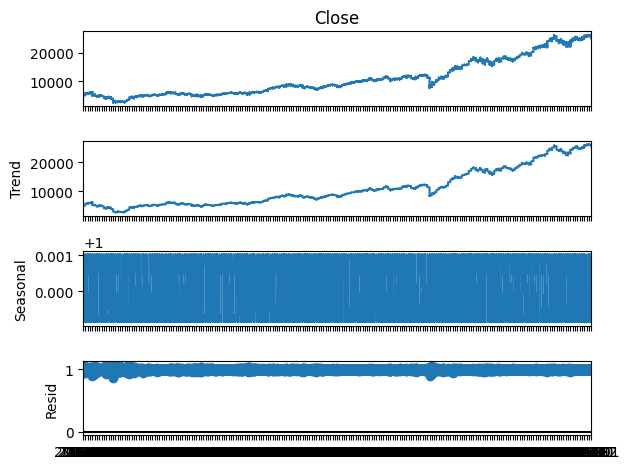

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df['Close'], 'multiplicative', period = 12)
res.plot()

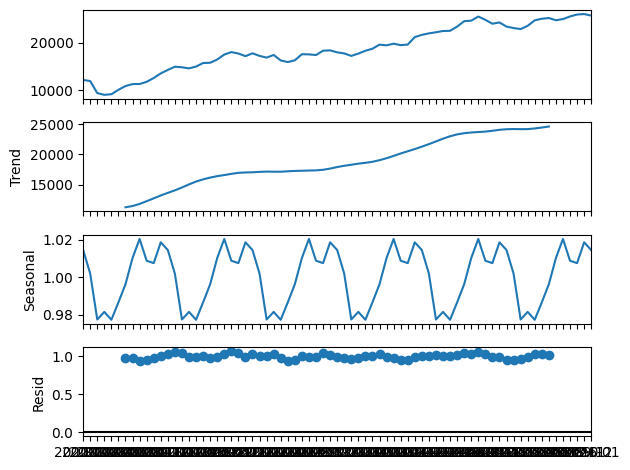

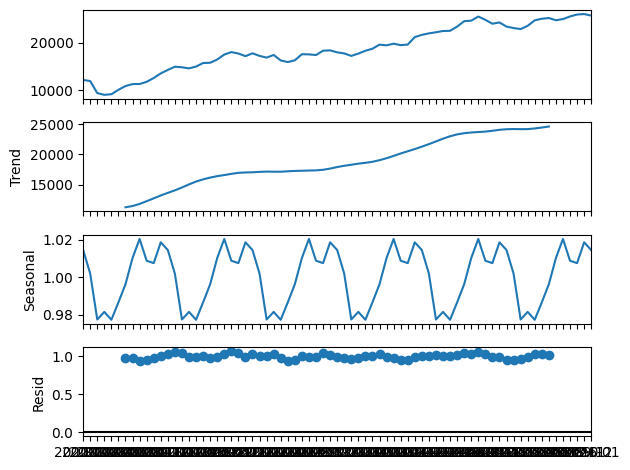

In [96]:
df_season = pd.DataFrame(df['Close'].groupby(df['month']).agg('mean'))
res = seasonal_decompose(df_season['2020-01': ], 'multiplicative', period = 12)
res.plot()

## LSTM

In [97]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from keras.layers import Dense,Dropout,Input,BatchNormalization,Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [98]:
nifty = yf.Ticker('^NSEI')
nifty_data = nifty.history(period = 'max')

nifty_data.head()

df = nifty_data
df.index = df.index.strftime('%Y-%m-%d')

In [99]:
df = pd.DataFrame({
    'close': df['Close'],
    'nxt_close': df['Close'].shift(-1)
}).dropna()


In [100]:
# df.dropna(inplace = True)
df.head()

,close,nxt_close
Date,,
2007-09-17,4494.649902,4546.200195
2007-09-18,4546.200195,4732.350098
2007-09-19,4732.350098,4747.549805
2007-09-20,4747.549805,4837.549805
2007-09-21,4837.549805,4932.200195


In [101]:
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()
df_scaled = pd.DataFrame(ms.fit_transform(df), columns = ['close', 'next_close'])

In [102]:
df_scaled.head()

,close,next_close
0,0.082777,0.084942
1,0.084942,0.092762
2,0.092762,0.093401
3,0.093401,0.097182
4,0.097182,0.101158


In [103]:
X = df_scaled[['close']].values      # input
y = df_scaled['next_close'].values   # target

In [104]:
X = X.reshape(X.shape[0], 1, 1)  # (samples, timesteps, features)

In [105]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(1, 1)),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


c:\Users\HP\Desktop\DATA\QUASTECH\ds-notes\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0463e-05 - val_loss: 4.6754e-04
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9415e-05 - val_loss: 4.6015e-04
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8099e-05 - val_loss: 4.4236e-04
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7000e-05 - val_loss: 3.1353e-04
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6462e-05 - val_loss: 2.7907e-04
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5713e-05 - val_loss: 2.0486e-04
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4697e-05 - val_loss: 1.8884e-04
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3749e-05 - val_loss: 1.7691e-04
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3091e-05 - val_loss: 1.1028e-04
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2633e-05 - val_loss: 1.0715e-04
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

In [110]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9966416267742603

In [119]:
last_xtest = X_test[-1].reshape(1, 1, 1)
pred_scaled = model.predict(last_xtest)

dummy = np.zeros((1, 2))
dummy[0, 1] = pred_scaled[0, 0]

pred_price = ms.inverse_transform(dummy)[0, 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [120]:
pred_price

np.float64(25219.100985129597)

In [123]:
df.tail()

,close,nxt_close
Date,,
2026-01-21,25157.500000,25289.900391
2026-01-22,25289.900391,25048.650391
2026-01-23,25048.650391,25175.400391
2026-01-27,25175.400391,25342.750000
2026-01-28,25342.750000,25429.150391
